In [3]:
import os
import pandas as pd
import numpy as np
from scipy.signal import welch
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Step 1: 加载原始数据
def load_raw_signals(data_folder, outcome_file, column_name="BCI"):
    """
    Load raw signals for Good and Bad Outcomes.
    
    Parameters:
    - data_folder: str, folder containing the raw EEG data files.
    - outcome_file: str, path to the CSV file containing patient outcomes.
    - column_name: str, the column name in the data files containing the signal.
    
    Returns:
    - dict: Contains raw signals and their corresponding labels.
    """
    outcomes = pd.read_csv(outcome_file)
    outcomes_dict = outcomes.set_index('pat_ID')['outcome'].to_dict()

    signals = []
    labels = []

    file_list = [f for f in os.listdir(data_folder) if f.endswith('.csv')]
    for file in file_list:
        patient_id = file.split('.')[0]
        if patient_id not in outcomes_dict:
            continue

        file_path = os.path.join(data_folder, file)
        data = pd.read_csv(file_path)
        if column_name not in data.columns:
            raise ValueError(f"Column '{column_name}' not found in {file}")
        
        raw_signal = data[column_name].values

        # 标记 Good 和 Bad Outcome
        label = 1 if outcomes_dict[patient_id] == 'Good Outcome' else 0
        signals.append(raw_signal)
        labels.append(label)

    return {"signals": signals, "labels": labels}

# Step 2: 特征提取
def extract_features(signals, fs=128):
    """
    Extract features from signals (time-domain and frequency-domain).
    
    Parameters:
    - signals: list of np.ndarray, raw signals.
    - fs: int, sampling frequency (default 128 Hz).
    
    Returns:
    - np.ndarray: Extracted features for each signal.
    """
    features = []
    for signal in signals:
        # 时域特征
        mean_val = np.mean(signal)
        std_val = np.std(signal)
        min_val = np.min(signal)
        max_val = np.max(signal)
        
        # 频域特征
        freqs, psd = welch(signal, fs=fs, nperseg=min(len(signal), 128))
        total_power = np.sum(psd)
        delta_power = np.sum(psd[(freqs >= 0.5) & (freqs < 4)])
        theta_power = np.sum(psd[(freqs >= 4) & (freqs < 8)])
        alpha_power = np.sum(psd[(freqs >= 8) & (freqs < 13)])
        beta_power = np.sum(psd[(freqs >= 13) & (freqs < 30)])
        
        features.append([
            mean_val, std_val, min_val, max_val,
            total_power, delta_power, theta_power, alpha_power, beta_power
        ])
    
    return np.array(features)

# Step 3: PCA 信息分析
def analyze_pca_information(features, n_components=None, threshold=0.01):
    """
    Analyze PCA to determine the number of informative components.
    
    Parameters:
    - features: np.ndarray, the extracted features.
    - n_components: int or None, the number of components for PCA (default: all components).
    - threshold: float, the threshold for determining non-zero principal components.
    
    Returns:
    - dict: Results of the analysis, including non-zero components and explained variance.
    """
    # 标准化特征
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)

    # PCA 分析
    pca = PCA(n_components=n_components)
    pca.fit(features_scaled)

    # 主成分贡献率
    explained_variance = pca.explained_variance_ratio_
    cumulative_variance = np.cumsum(explained_variance)

    # 非零主成分数量
    non_zero_components = np.sum(explained_variance > threshold)

    # 打印结果
    print(f"Explained Variance Ratio for each component:\n{explained_variance}")
    print(f"Cumulative Variance Ratio:\n{cumulative_variance}")
    print(f"Number of components with variance > {threshold}: {non_zero_components}")
    
    return {
        "explained_variance_ratio": explained_variance,
        "cumulative_variance_ratio": cumulative_variance,
        "non_zero_components": non_zero_components
    }

# Step 4: 主成分可视化
def plot_pca_variance(pca_info):
    """
    Plot explained variance and cumulative variance.
    
    Parameters:
    - pca_info: dict, output from analyze_pca_information function.
    """
    explained_variance = pca_info["explained_variance_ratio"]
    cumulative_variance = pca_info["cumulative_variance_ratio"]

    plt.figure(figsize=(12, 6))
    plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.7, label="Explained Variance")
    plt.step(range(1, len(cumulative_variance) + 1), cumulative_variance, where="mid", label="Cumulative Variance", color='red')
    plt.xlabel("Principal Component Index")
    plt.ylabel("Variance Ratio")
    plt.title("Explained and Cumulative Variance by Principal Components")
    plt.legend()
    plt.grid(True)
    plt.show()

# Step 5: PCA 数据分布可视化
def plot_pca_distribution(features, labels, n_components=2):
    """
    Perform PCA on the features and plot the first two principal components.
    
    Parameters:
    - features: np.ndarray, the extracted features.
    - labels: list, corresponding labels for the signals (0 or 1).
    - n_components: int, number of principal components to reduce to.
    """
    # 标准化特征
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)

    # PCA 降维
    pca = PCA(n_components=n_components)
    pca_result = pca.fit_transform(features_scaled)

    # 可视化主成分
    plt.figure(figsize=(10, 6))
    for label, color, marker in zip([0, 1], ['red', 'blue'], ['o', 'x']):
        plt.scatter(
            pca_result[np.array(labels) == label, 0], 
            pca_result[np.array(labels) == label, 1], 
            c=color, label='Good Outcome' if label == 1 else 'Bad Outcome', 
            alpha=0.6, marker=marker
        )
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title('PCA Distribution of EEG Signal Features')
    plt.legend()
    plt.grid(True)
    plt.show()



Explained Variance Ratio for each component:
[0.51217204 0.22301592 0.09222824 0.07542803 0.04595369 0.02580819
 0.01468491 0.00971851 0.00099047]
Cumulative Variance Ratio:
[0.51217204 0.73518796 0.8274162  0.90284423 0.94879792 0.97460611
 0.98929102 0.99900953 1.        ]
Number of components with variance > 0.01: 7


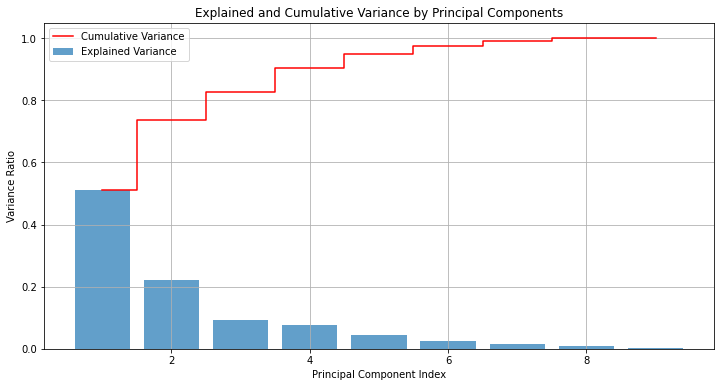

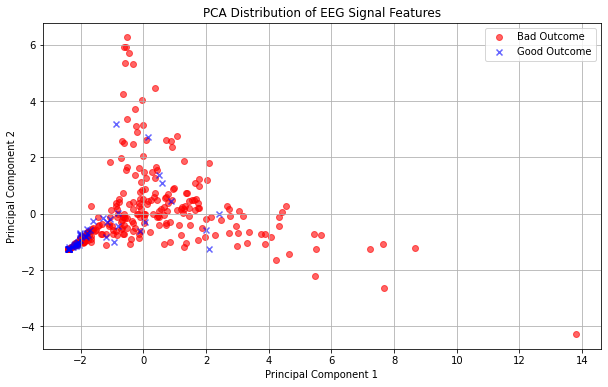

In [4]:
# 主函数示例调用
if __name__ == "__main__":
    data_folder = '5min_smoothed_data/'  # 替换为实际数据文件夹路径
    outcome_file = 'valid_patients_outcome.csv'  # 替换为实际标签文件路径

    # 加载原始数据
    data = load_raw_signals(data_folder, outcome_file, column_name="BCI")

    # 提取特征
    features = extract_features(data["signals"])
    labels = np.array(data["labels"])

    # PCA 信息分析
    pca_info = analyze_pca_information(features, n_components=None, threshold=0.01)

    # 可视化主成分贡献率
    plot_pca_variance(pca_info)

    # 可视化 PCA 分布
    plot_pca_distribution(features, labels, n_components=2)

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import torch as torch
import pywt
from scipy.signal import welch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import torch.optim as optim
from xgboost import XGBClassifier

In [6]:
import numpy as np
import pywt
from scipy.signal import welch
import os
import pandas as pd
import torch
from torch.utils.data import Dataset

class EEGUtil:
    @staticmethod
    def load_data(file_path, column_name='BCI'):
        """Load EEG data from a CSV file."""
        data = pd.read_csv(file_path)
        signal = data[column_name].values
        return signal

    @staticmethod
    def padding(signal, target_length, mode="constant", constant_value=-1):
        """Pad or truncate signal to the target length with various strategies."""
        signal = np.array(signal)
        current_length = len(signal)
        
        if current_length >= target_length:
            return signal[:target_length]

        padding_size = target_length - current_length

        if mode == "constant":
            return np.pad(signal, (0, padding_size), 'constant', constant_values=constant_value)
        elif mode == "reflect":
            return np.pad(signal, (0, padding_size), 'reflect')
        elif mode == "cyclic":
            return np.pad(signal, (0, padding_size), 'wrap')
        elif mode == "edge":
            return np.pad(signal, (0, padding_size), 'edge')
        elif mode == "random":
            random_padding = np.random.uniform(low=np.min(signal), high=np.max(signal), size=padding_size)
            return np.concatenate((signal, random_padding))
        else:
            raise ValueError(f"Unsupported padding mode: {mode}")

    @staticmethod
    def wavelet_transform(signal):
        """Perform Wavelet Transform and extract features."""
        coeffs = pywt.wavedec(signal, 'db4', level=5)
        features = []
        for i in range(1, len(coeffs)):
            features.extend([np.mean(coeffs[i]), np.std(coeffs[i])])
        return np.array(features)

    @staticmethod
    def psd_transform(signal, fs=0.2, nperseg=128):
        """Perform Power Spectral Density analysis and extract features."""
        _, psd = welch(signal, fs=fs, nperseg=nperseg)
        return psd

In [7]:
class EEGDataset(Dataset):
    def __init__(self, data_folder, outcome_file=None, target_length=600, strategy='padding', padding_mode="constant", use_labels=False):
        """
        Dataset for EEG signals with various preprocessing strategies.
        
        Parameters:
        - data_folder: str, folder containing EEG data files.
        - outcome_file: str, path to CSV file containing outcomes (optional).
        - target_length: int, length to pad/truncate signals to.
        - strategy: str, preprocessing strategy ('padding', 'wavelet', 'psd').
        - padding_mode: str, padding mode for 'padding' strategy.
        - use_labels: bool, whether to load labels from the outcome file.
        """
        self.use_labels = use_labels
        self.data_folder = data_folder
        self.target_length = target_length
        self.strategy = strategy
        self.padding_mode = padding_mode
        self.file_list = [f for f in os.listdir(data_folder) if f.endswith('.csv')]
        
        # Load outcomes if provided
        self.outcome_dict = {}
        if use_labels and outcome_file is not None:
            self.outcome_data = pd.read_csv(outcome_file)
            self.outcome_dict = self.outcome_data.set_index('pat_ID')['outcome'].to_dict()
            # Only retain files with labels
            self.file_list = [f for f in self.file_list if f.split('.')[0] in self.outcome_dict]

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        filename = self.file_list[idx]
        patient_id = filename.split('.')[0]
        file_path = os.path.join(self.data_folder, filename)
        signal = EEGUtil.load_data(file_path, column_name='spike hz')

        # Process the signal
        processed_signal = self.process_signal(signal)

        # Get the label if available
        label = -1
        if self.use_labels:
            label = self.get_label(patient_id)
            
        return torch.tensor(processed_signal, dtype=torch.float32).unsqueeze(0), label  # Add channel dimension

    def process_signal(self, signal):
        if self.strategy == 'padding':
            return EEGUtil.padding(signal, self.target_length, mode=self.padding_mode)
        elif self.strategy == 'wavelet':
            return EEGUtil.wavelet_transform(signal)
        elif self.strategy == 'psd':
            return EEGUtil.psd_transform(signal)
        else:
            raise ValueError("Invalid processing strategy")

    def get_label(self, patient_id):
        if patient_id in self.outcome_dict:
            outcome = self.outcome_dict[patient_id]
            return 1 if outcome == 'Good Outcome' else 0

In [8]:
initial_channels = 128
class CNNEncoder(nn.Module):
    def __init__(self, latent_dim):
        super(CNNEncoder, self).__init__()
        self.latent_dim = latent_dim

        layers = [
            nn.Conv1d(1, initial_channels, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU()
        ]

        in_channels = initial_channels
        for i in range(3):  # 3 more layers to make 4 in total
            out_channels = in_channels // 2
            layers.extend([
                nn.Conv1d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
                nn.LeakyReLU()
            ])
            in_channels = out_channels

        self.encoder = nn.Sequential(*layers)
        self.fc_mean = nn.Linear(in_channels * seq_length, latent_dim)
        self.fc_logvar = nn.Linear(in_channels * seq_length, latent_dim)

    def forward(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        mean = self.fc_mean(x)
        logvar = self.fc_logvar(x)
        return mean, logvar

class CNNDecoder(nn.Module):
    def __init__(self, latent_dim):
        super(CNNDecoder, self).__init__()
        self.latent_dim = latent_dim
        self.fc = nn.Linear(latent_dim, initial_channels // 8 * seq_length)  # Match the output channel of the encoder

        layers = [nn.LeakyReLU()]
        in_channels = initial_channels // 8
        for i in range(3):
            out_channels = in_channels * 2
            layers.extend([
                nn.ConvTranspose1d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
                nn.LeakyReLU()
            ])
            in_channels = out_channels
        
        # Remove the last LeakyReLU and add a final ConvTranspose to match the Encoder's starting channel
        layers.pop()
        layers.append(nn.ConvTranspose1d(in_channels, 1, kernel_size=3, stride=1, padding=1))

        self.decoder = nn.Sequential(*layers)

    def forward(self, z):
        x = self.fc(z)
        x = x.view(x.size(0), initial_channels // 8, seq_length)
        x = self.decoder(x)
        return F.leaky_relu(x)


class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = CNNEncoder(latent_dim)
        self.decoder = CNNDecoder(latent_dim)

    def reparameterize(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mean + eps * std

    def forward(self, x):
        mean, logvar = self.encoder(x)
        z = self.reparameterize(mean, logvar)
        reconstruction = self.decoder(z)
        return reconstruction, mean, logvar
    
    def get_embedding(self, x):
        self.eval()
        with torch.no_grad():
            mean, logvar = self.encoder(x)
            z = self.reparameterize(mean, logvar)
        return z

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


In [9]:
def train(model, dataloader, optimizer, criterion, alpha, kl_loss_enabled=True):
    model.train()  # Set the model to training mode
    running_loss = 0.0

    for data, label in dataloader:  # We don't use the labels during unsupervised training for VAE
        data = data.to(device)
        optimizer.zero_grad()

        # Forward pass through the model
        reconstruction, mean, logvar = model(data)

        # Compute the reconstruction loss (mean squared error)
        recon_loss = criterion(reconstruction, data)

        # Compute the KL divergence loss
        kl_loss = -0.5 * torch.mean(1 + logvar - mean.pow(2) - logvar.exp())

        # Combine the losses
        loss = recon_loss + (alpha * kl_loss if kl_loss_enabled else 0)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * data.size(0)  # Accumulate the total loss for this batch

    epoch_loss = running_loss / len(dataloader.dataset)  # Calculate the average loss per sample
    return epoch_loss


def test(model, dataloader, criterion):
    model.eval()
    running_loss = 0
    with torch.no_grad():
        for data, label in dataloader:  # 注意：解包数据，将信号和标签分别取出
            data = data.to(device)
            reconstruction, _, _ = model(data)
            loss = criterion(reconstruction, data)
            running_loss += loss.item() * data.size(0)
    return running_loss / len(dataloader.dataset)

def get_latent_variables(model, dataloader):
    model.eval()
    all_latent_vars = []
    with torch.no_grad():
        for data, label  in dataloader:
            data = data.to(device)
            _, mean, _ = model(data)
            all_latent_vars.append(mean.detach().cpu())
    return torch.cat(all_latent_vars)

In [10]:
def extract_latent_features(vae_model, dataset):
    latent_features = []
    labels = []

    for i in range(len(dataset)):
        signal, label = dataset[i]  # 从数据集中获取信号和标签

        # 将信号放入设备
        signal = signal.unsqueeze(0).to(device)  # 增加 batch 维度

        # 获取潜在表示
        with torch.no_grad():
            latent_vector = vae_model.get_embedding(signal).cpu().numpy()
        latent_features.append(latent_vector.flatten())

        
        
        labels.append(label)

    return np.array(latent_features), np.array(labels)

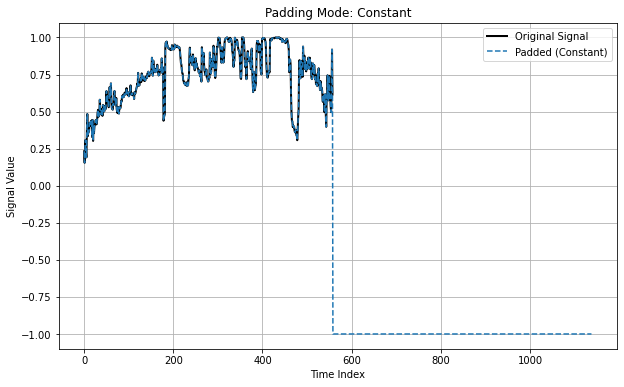

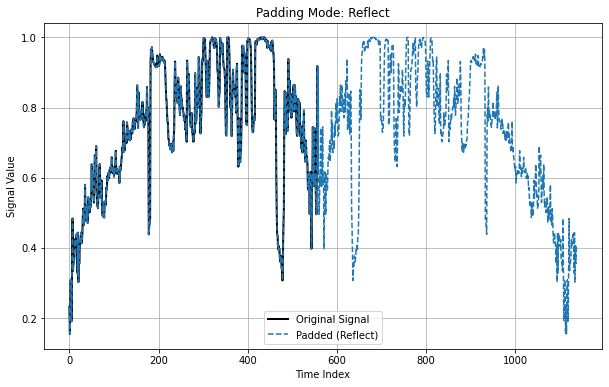

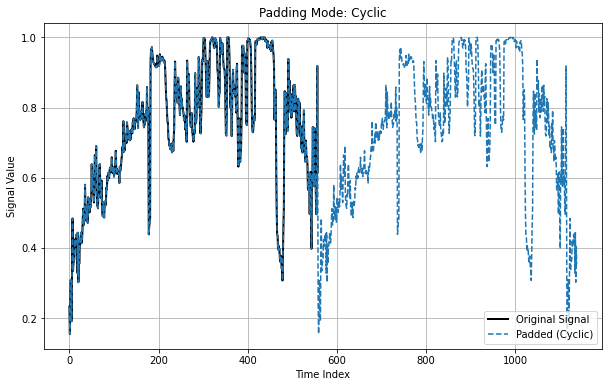

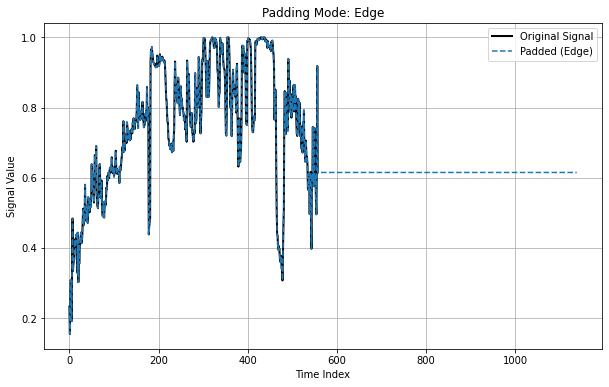

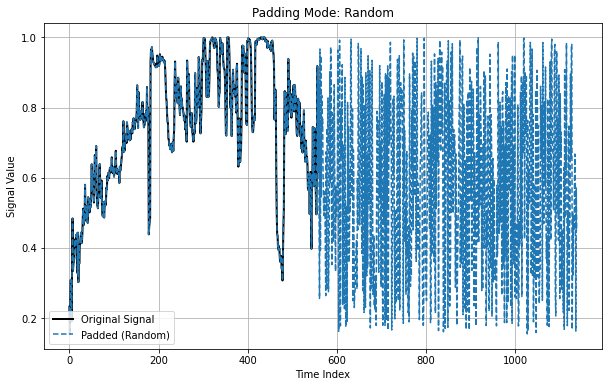

In [11]:
import random
def visualize_padding_effect(data_folder, outcome_file, target_length, padding_modes):
    """
    Visualize the effects of different padding modes on a randomly loaded raw signal with individual plots.
    
    Parameters:
    - data_folder: str, folder containing the EEG data files.
    - outcome_file: str, path to the outcome CSV file.
    - target_length: int, the target length for padding.
    - padding_modes: list of str, the padding modes to compare.
    """
    # Step 1: 加载数据文件列表
    file_list = [f for f in os.listdir(data_folder) if f.endswith('.csv')]
    random_file = random.choice(file_list)  # 随机选择一个文件
    raw_signal = EEGUtil.load_data(os.path.join(data_folder, random_file), column_name='BCI')  # 原始信号

    # Step 2: 对信号应用不同的填充策略并分别绘制
    for mode in padding_modes:
        padded_signal = EEGUtil.padding(raw_signal, target_length, mode=mode)

        # 创建单独的图表
        plt.figure(figsize=(10, 6))
        plt.plot(raw_signal, label='Original Signal', color='black', linewidth=2)
        plt.plot(padded_signal, label=f'Padded ({mode.capitalize()})', linestyle='--')
        plt.xlabel('Time Index')
        plt.ylabel('Signal Value')
        plt.title(f'Padding Mode: {mode.capitalize()}')
        plt.legend()
        plt.grid(True)
        plt.show()

# 示例代码：使用原始数据文件和不同填充策略
padding_modes = ["constant", "reflect", "cyclic", "edge", "random"]
target_length = 1139  # 目标填充长度

# 可视化填充效果
visualize_padding_effect(
    data_folder='5min_smoothed_data/',
    outcome_file='valid_patients_outcome.csv',
    target_length=target_length,
    padding_modes=padding_modes
)

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

def visualize_good_bad_signals(dataset):
    """
    Visualize and compare signals for Good and Bad Outcomes.
    
    Parameters:
    - dataset: EEGDataset object, the dataset containing EEG signals.
    """
    # Step 1: 提取 Good 和 Bad Outcome 信号
    good_signals = []
    bad_signals = []
    
    for idx in range(len(dataset)):
        raw_signal, label = dataset[idx]
        raw_signal = raw_signal.squeeze(0).numpy()  # 转为 NumPy 格式
        
        if label == 1:  # Good Outcome
            good_signals.append(raw_signal)
        elif label == 0:  # Bad Outcome
            bad_signals.append(raw_signal)
    
    # Step 2: 绘制 Good 和 Bad Outcome 的平均信号波形
    plt.figure(figsize=(10, 6))
    plt.plot(np.mean(good_signals, axis=0), label='Good Outcome (Mean Signal)', color='blue')
    plt.plot(np.mean(bad_signals, axis=0), label='Bad Outcome (Mean Signal)', color='red')
    plt.fill_between(range(len(good_signals[0])),
                     np.mean(good_signals, axis=0) - np.std(good_signals, axis=0),
                     np.mean(good_signals, axis=0) + np.std(good_signals, axis=0),
                     color='blue', alpha=0.2)
    plt.fill_between(range(len(bad_signals[0])),
                     np.mean(bad_signals, axis=0) - np.std(bad_signals, axis=0),
                     np.mean(bad_signals, axis=0) + np.std(bad_signals, axis=0),
                     color='red', alpha=0.2)
    plt.xlabel('Time Index')
    plt.ylabel('Signal Value')
    plt.title('Mean Signal Waveforms for Good and Bad Outcomes')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Step 3: 提取信号特征并绘制分布
    good_features = []
    bad_features = []
    
    for signal in good_signals:
        features = EEGUtil.wavelet_transform(signal)
        good_features.append(features)
        
    for signal in bad_signals:
        features = EEGUtil.wavelet_transform(signal)
        bad_features.append(features)

    # 转为 DataFrame 便于分析
    good_df = pd.DataFrame(good_features, columns=[f'Wavelet_Feature_{i}' for i in range(len(good_features[0]))])
    bad_df = pd.DataFrame(bad_features, columns=[f'Wavelet_Feature_{i}' for i in range(len(bad_features[0]))])
    
    # Step 4: 可视化特征分布（以第一个特征为例）
    plt.figure(figsize=(10, 6))
    sns.kdeplot(good_df.iloc[:, 0], label='Good Outcome', color='blue', shade=True)
    sns.kdeplot(bad_df.iloc[:, 0], label='Bad Outcome', color='red', shade=True)
    plt.xlabel('Feature Value')
    plt.ylabel('Density')
    plt.title('Distribution of Wavelet Feature 0 for Good and Bad Outcomes')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    
def visualize_all_signals(dataset):
    """
    Visualize all signals for Good and Bad Outcomes, including their mean waveforms.
    
    Parameters:
    - dataset: EEGDataset object, the dataset containing EEG signals.
    """
    # Step 1: 提取 Good 和 Bad Outcome 信号
    good_signals = []
    bad_signals = []
    
    for idx in range(len(dataset)):
        raw_signal, label = dataset[idx]
        raw_signal = raw_signal.squeeze(0).numpy()  # 转为 NumPy 格式
        
        if label == 1:  # Good Outcome
            good_signals.append(raw_signal)
        elif label == 0:  # Bad Outcome
            bad_signals.append(raw_signal)

    # Step 2: 绘制所有 Good Outcome 信号
    plt.figure(figsize=(14, 8))
    #for signal in good_signals:
        #plt.plot(signal, color='blue', alpha=0.3, linewidth=0.5)
    
    # 绘制 Good Outcome 平均值和标准差
    good_mean = np.mean(good_signals, axis=0)
    good_std = np.std(good_signals, axis=0)
    plt.plot(good_mean, color='blue', label='Good Outcome (Mean)', linewidth=2)
    plt.fill_between(range(len(good_mean)), good_mean - good_std, good_mean + good_std, color='blue', alpha=0.2)

    # Step 3: 绘制所有 Bad Outcome 信号
    #for signal in bad_signals:
        #plt.plot(signal, color='red', alpha=0.3, linewidth=0.5)
    
    # 绘制 Bad Outcome 平均值和标准差
    bad_mean = np.mean(bad_signals, axis=0)
    bad_std = np.std(bad_signals, axis=0)
    plt.plot(bad_mean, color='red', label='Bad Outcome (Mean)', linewidth=2)
    plt.fill_between(range(len(bad_mean)), bad_mean - bad_std, bad_mean + bad_std, color='red', alpha=0.2)

    # 图表设置
    plt.xlabel('Time Index')
    plt.ylabel('Signal Value')
    plt.title('Visualization of All Signals (Good vs. Bad Outcomes)')
    plt.legend()
    plt.grid(True)
    plt.show()

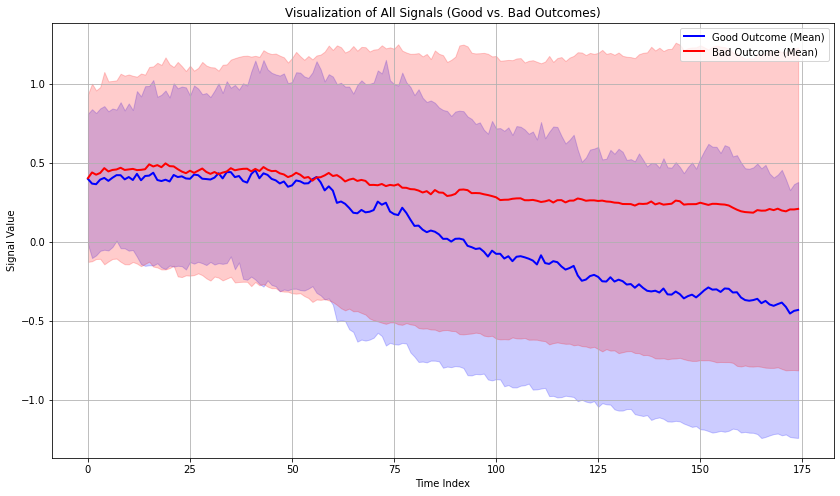

In [14]:
# 创建 EEG 数据集对象
data_folder = '5min_smoothed_data/'
outcome_file = 'valid_patients_outcome.csv'

eeg_dataset = EEGDataset(
    data_folder=data_folder,
    outcome_file=outcome_file,
    target_length=175,
    strategy='padding',
    padding_mode='constant',
    use_labels=True
)

# 可视化 Good 和 Bad Outcome 的信号区别
#visualize_good_bad_signals(eeg_dataset)
# 可视化所有信号和平均波形
visualize_all_signals(eeg_dataset)

In [22]:
import os
import pandas as pd
import numpy as np

def calculate_raw_length_stats(data_folder, outcome_file, column_name="BCI"):
    """
    Calculate the average and maximum lengths of raw signals for Good and Bad Outcomes.
    
    Parameters:
    - data_folder: str, folder containing the raw EEG data files.
    - outcome_file: str, path to the CSV file containing patient outcomes.
    - column_name: str, the column name in the data files containing the signal.
    
    Returns:
    - dict: A dictionary with the length statistics for Good and Bad Outcomes.
    """
    # 加载 outcome 数据
    outcomes = pd.read_csv(outcome_file)
    outcomes_dict = outcomes.set_index('pat_ID')['outcome'].to_dict()

    # 初始化长度列表
    good_lengths = []
    bad_lengths = []

    # 遍历所有文件
    file_list = [f for f in os.listdir(data_folder) if f.endswith('.csv')]
    for file in file_list:
        patient_id = file.split('.')[0]  # 提取文件名中的 patient ID
        if patient_id not in outcomes_dict:
            continue  # 跳过没有 outcome 标签的数据

        # 加载信号
        file_path = os.path.join(data_folder, file)
        data = pd.read_csv(file_path)
        if column_name not in data.columns:
            raise ValueError(f"Column '{column_name}' not found in {file}")
        
        raw_signal = data[column_name].values
        signal_length = len(raw_signal)  # 获取信号长度

        # 根据 outcome 分类
        if outcomes_dict[patient_id] == 'Good Outcome':
            good_lengths.append(signal_length)
        else:
            bad_lengths.append(signal_length)

    # 计算统计值
    good_stats = {
        "mean_length": np.mean(good_lengths),
        "max_length": np.max(good_lengths)
    }
    bad_stats = {
        "mean_length": np.mean(bad_lengths),
        "max_length": np.max(bad_lengths)
    }

    # 返回结果
    return {
        "good_outcome": good_stats,
        "bad_outcome": bad_stats
    }

# 示例调用
data_folder = '5min_smoothed_data/'
outcome_file = 'valid_patients_outcome.csv'

length_stats = calculate_raw_length_stats(data_folder, outcome_file, column_name="BCI")
print("Good Outcome Length Stats:", length_stats["good_outcome"])
print("Bad Outcome Length Stats:", length_stats["bad_outcome"])

Good Outcome Length Stats: {'mean_length': 174.3653846153846, 'max_length': 808}
Bad Outcome Length Stats: {'mean_length': 313.4227642276423, 'max_length': 1139}


In [23]:
def extract_valid_signals(data_folder, outcome_file, column_name="BCI"):
    """
    Extract valid signals (excluding padded data) for Good and Bad Outcomes.
    
    Parameters:
    - data_folder: str, folder containing the raw EEG data files.
    - outcome_file: str, path to the CSV file containing patient outcomes.
    - column_name: str, the column name in the data files containing the signal.
    
    Returns:
    - dict: Contains valid signals for Good and Bad Outcomes.
    """
    outcomes = pd.read_csv(outcome_file)
    outcomes_dict = outcomes.set_index('pat_ID')['outcome'].to_dict()

    good_signals = []
    bad_signals = []

    file_list = [f for f in os.listdir(data_folder) if f.endswith('.csv')]
    for file in file_list:
        patient_id = file.split('.')[0]
        if patient_id not in outcomes_dict:
            continue

        file_path = os.path.join(data_folder, file)
        data = pd.read_csv(file_path)
        if column_name not in data.columns:
            raise ValueError(f"Column '{column_name}' not found in {file}")
        
        raw_signal = data[column_name].values
        signal_length = len(raw_signal)  # 信号有效长度

        # 分类信号
        if outcomes_dict[patient_id] == 'Good Outcome':
            good_signals.append(raw_signal[:signal_length])
        else:
            bad_signals.append(raw_signal[:signal_length])
    
    return {"good_signals": good_signals, "bad_signals": bad_signals}

In [24]:
def visualize_good_outcome_patterns(good_signals):
    """
    Visualize patterns in Good Outcome signals (excluding padding).
    
    Parameters:
    - good_signals: list of np.ndarray, the valid Good Outcome signals.
    """
    # Step 1: 绘制所有 Good Outcome 信号
    plt.figure(figsize=(14, 8))
    for signal in good_signals:
        plt.plot(signal, color='blue', alpha=0.2, linewidth=0.5)

    # Step 2: 计算平均信号和标准差
    max_length = max(len(signal) for signal in good_signals)
    aligned_signals = np.array([np.pad(signal, (0, max_length - len(signal)), 'constant', constant_values=np.nan)
                                for signal in good_signals])
    mean_signal = np.nanmean(aligned_signals, axis=0)
    std_signal = np.nanstd(aligned_signals, axis=0)

    # 绘制平均信号和标准差范围
    plt.plot(mean_signal, color='blue', label='Good Outcome (Mean)', linewidth=2)
    plt.fill_between(range(len(mean_signal)), 
                     mean_signal - std_signal, 
                     mean_signal + std_signal, 
                     color='blue', alpha=0.2)
    
    plt.xlabel('Time Index')
    plt.ylabel('Signal Value')
    plt.title('Good Outcome Patterns (Excluding Padding)')
    plt.legend()
    plt.grid(True)
    plt.show()

In [25]:
from scipy.signal import welch
import pandas as pd

def calculate_good_outcome_features(good_signals):
    """
    Calculate features of Good Outcome signals (time-domain and frequency-domain).
    
    Parameters:
    - good_signals: list of np.ndarray, the valid Good Outcome signals.
    
    Returns:
    - pd.DataFrame: A DataFrame containing features of each signal.
    """
    features = []
    for signal in good_signals:
        # 时域特征
        mean_val = np.mean(signal)
        std_val = np.std(signal)
        min_val = np.min(signal)
        max_val = np.max(signal)
        
        # 频域特征
        freqs, psd = welch(signal, fs=128, nperseg=128)  # 假设采样频率为 128 Hz
        total_power = np.sum(psd)
        delta_power = np.sum(psd[(freqs >= 0.5) & (freqs < 4)])
        theta_power = np.sum(psd[(freqs >= 4) & (freqs < 8)])
        alpha_power = np.sum(psd[(freqs >= 8) & (freqs < 13)])
        beta_power = np.sum(psd[(freqs >= 13) & (freqs < 30)])
        
        features.append({
            "mean": mean_val,
            "std": std_val,
            "min": min_val,
            "max": max_val,
            "total_power": total_power,
            "delta_power": delta_power,
            "theta_power": theta_power,
            "alpha_power": alpha_power,
            "beta_power": beta_power
        })
    
    return pd.DataFrame(features)

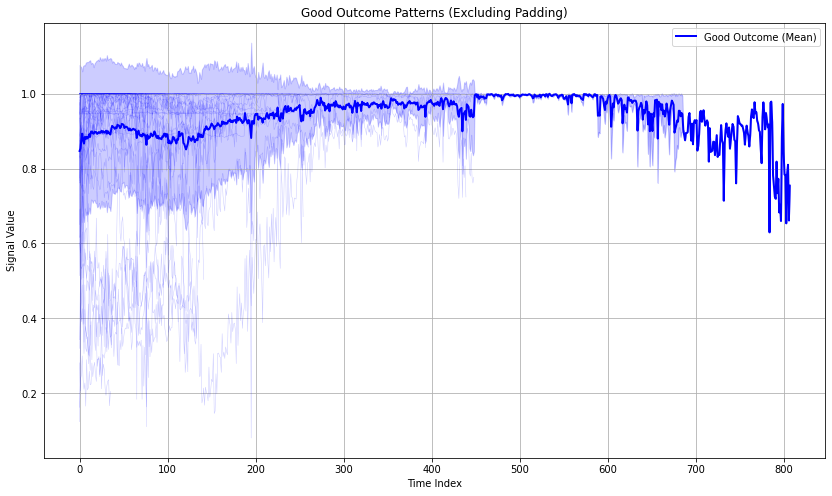

            mean        std        min        max  total_power  delta_power  \
count  52.000000  52.000000  52.000000  52.000000    52.000000    52.000000   
mean    0.895547   0.049530   0.691768   0.973459     0.001759     0.000819   
std     0.170499   0.056350   0.298230   0.092273     0.003425     0.001953   
min     0.379808   0.000000   0.080557   0.489607     0.000000     0.000000   
25%     0.900886   0.013635   0.573440   0.996266     0.000041     0.000007   
50%     0.958473   0.027457   0.781146   1.000000     0.000212     0.000054   
75%     0.991228   0.064991   0.936242   1.000000     0.000966     0.000338   
max     0.999993   0.253495   0.999573   1.000000     0.017001     0.010309   

        theta_power  alpha_power  beta_power  
count  5.200000e+01    52.000000   52.000000  
mean   2.270354e-04     0.000157    0.000195  
std    5.316672e-04     0.000484    0.000339  
min    0.000000e+00     0.000000    0.000000  
25%    2.159525e-07     0.000002    0.000003  
50%   

/Users/yinziyuan/opt/anaconda3/lib/python3.9/site-packages/scipy/signal/_spectral_py.py:2017: UserWarning: nperseg = 128 is greater than input length  = 1, using nperseg = 1
  warnings.warn('nperseg = {0:d} is greater than input length '
/Users/yinziyuan/opt/anaconda3/lib/python3.9/site-packages/scipy/signal/_spectral_py.py:2017: UserWarning: nperseg = 128 is greater than input length  = 120, using nperseg = 120
  warnings.warn('nperseg = {0:d} is greater than input length '
/Users/yinziyuan/opt/anaconda3/lib/python3.9/site-packages/scipy/signal/_spectral_py.py:2017: UserWarning: nperseg = 128 is greater than input length  = 87, using nperseg = 87
  warnings.warn('nperseg = {0:d} is greater than input length '
/Users/yinziyuan/opt/anaconda3/lib/python3.9/site-packages/scipy/signal/_spectral_py.py:2017: UserWarning: nperseg = 128 is greater than input length  = 13, using nperseg = 13
  warnings.warn('nperseg = {0:d} is greater than input length '
/Users/yinziyuan/opt/anaconda3/lib/pytho

In [26]:
# 加载原始信号数据
data_folder = '5min_smoothed_data/'
outcome_file = 'valid_patients_outcome.csv'

signals = extract_valid_signals(data_folder, outcome_file, column_name="BCI")

# 可视化 Good Outcome 的模式
visualize_good_outcome_patterns(signals["good_signals"])

# 计算 Good Outcome 的特征
good_features = calculate_good_outcome_features(signals["good_signals"])
print(good_features.describe())  # 查看特征统计

In [27]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

# 定义不同的填充策略
padding_modes = ["constant", "reflect", "cyclic", "edge", "random"]

# 存储每种策略的实验结果
results = {mode: {"train_losses": [], "test_losses": [], "accuracy": None, "classification_report": None, "confusion_matrix": None} for mode in padding_modes}

# 超参数设置
latent_dim = 7
seq_length = 1139
batch_size = 32
epochs = 100
alpha = 1e-6
patience = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 数据文件路径
data_folder = '5min_smoothed_data/'
outcome_file = 'valid_patients_outcome.csv'

for mode in padding_modes:
    print(f"\n=== Experiment with Padding Mode: {mode} ===")
    
    # Step 1: 数据加载与处理
    eeg_dataset = EEGDataset(data_folder, outcome_file, target_length=seq_length, strategy='padding', padding_mode=mode, use_labels=False)
    train_size = int(0.8 * len(eeg_dataset))
    test_size = len(eeg_dataset) - train_size
    train_dataset, test_dataset = torch.utils.data.random_split(eeg_dataset, [train_size, test_size])
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    # Step 2: 定义模型并训练
    vae_model = VAE(latent_dim).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(vae_model.parameters(), lr=1e-3, weight_decay=1e-4)

    train_losses = []
    test_losses = []
    best_test_loss = float('inf')
    epochs_no_improve = 0

    for epoch in range(epochs):
        train_loss = train(vae_model, train_loader, optimizer, criterion, alpha)
        test_loss = test(vae_model, test_loader, criterion)
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        
        print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")

        # 早停机制
        if test_loss < best_test_loss:
            best_test_loss = test_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print(f"Early stopping after {patience} epochs without improvement.")
            break
    
    results[mode]["train_losses"] = train_losses
    results[mode]["test_losses"] = test_losses

    # Step 3: 提取潜在特征和标签
    eeg_dataset = EEGDataset(data_folder, outcome_file, target_length=seq_length, strategy='padding', padding_mode=mode, use_labels=True)
    latent_features, labels = extract_latent_features(vae_model, eeg_dataset)

    # Step 4: 划分训练集和测试集（分类任务）
    X_train, X_test, y_train, y_test = train_test_split(latent_features, labels, test_size=0.2, random_state=42, stratify=labels)

    # Step 5: 训练 XGBoost 分类器
    xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
    xgb_model.fit(X_train, y_train)

    # Step 6: 测试并评估分类器
    y_pred = xgb_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)

    results[mode]["accuracy"] = accuracy
    results[mode]["classification_report"] = class_report
    results[mode]["confusion_matrix"] = conf_matrix

    print(f"\n=== Results for Padding Mode: {mode} ===")
    print(f"Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(class_report)
    print("\nConfusion Matrix:")
    print(conf_matrix)

# 绘制各填充模式的测试损失曲线
plt.figure(figsize=(12, 6))
for mode in padding_modes:
    plt.plot(results[mode]["test_losses"], label=f'Test Loss ({mode})')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Test Loss for Different Padding Modes')
plt.legend()
plt.grid(True)
plt.show()

# 打印所有填充模式的最终分类精度
print("\nFinal Classification Accuracy for Each Padding Mode:")
for mode in padding_modes:
    print(f"{mode.capitalize()} Padding: Accuracy = {results[mode]['accuracy']:.4f}")


=== Experiment with Padding Mode: constant ===


KeyboardInterrupt: 

Epoch 1/3, Train Loss: 0.1089, Test Loss: 0.0781
Epoch 2/3, Train Loss: 0.0472, Test Loss: 0.0246
Epoch 3/3, Train Loss: 0.0231, Test Loss: 0.0165


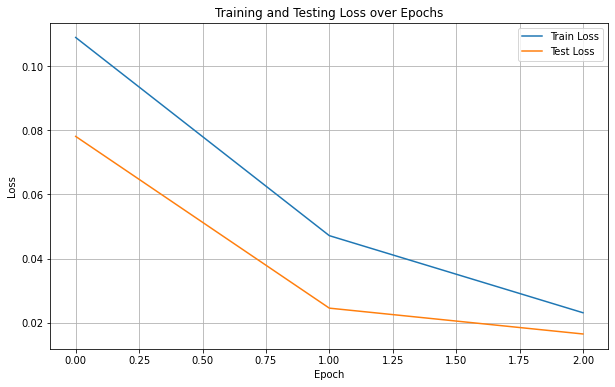

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import pandas as pd

# 設置設備
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 超參數設置
latent_dim = 7  # 潛在空間的維度
initial_channels = 128  # CNN 的初始通道數
seq_length = 1139  # 填充或截斷的序列長度 此處設為最長
batch_size = 32
epochs = 3
alpha = 1e-6  # KL 損失的權重
patience = 10  # 定义在多少个 epoch 不改善后停止训练
padding_method='reflect'# 使用反射填充

# 定義數據文件夾路徑
data_folder = '5min_smoothed_data/'  # 替換為你實際的數據文件夾路徑
valid_outcome_data = 'valid_patients_outcome.csv'

# 创建 EEG 数据集并使用不同的填充模式
eeg_dataset = EEGDataset(
    data_folder='5min_smoothed_data/',
    outcome_file='valid_patients_outcome.csv',
    target_length=1139,
    strategy='padding',
    padding_mode= padding_method, 
    use_labels=False
)
train_size = int(0.8 * len(eeg_dataset))
test_size = len(eeg_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(eeg_dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
# 定义模型、损失函数和优化器
vae_model = VAE(latent_dim).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(vae_model.parameters(), lr=1e-3, weight_decay=1e-4)

# 训练和测试损失列表，用于绘制曲线
train_losses = []
test_losses = []

# 早停相关变量
best_test_loss = float('inf')
epochs_no_improve = 0

# 训练循环
for epoch in range(epochs):
    train_loss = train(vae_model, train_loader, optimizer, criterion, alpha)
    test_loss = test(vae_model, test_loader, criterion)
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    
    print(f'Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

    # 检查早停条件
    if test_loss < best_test_loss:
        best_test_loss = test_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
    
    if epochs_no_improve >= patience:
        print("Validation loss has not improved for {} epochs. Early stopping...".format(patience))
        break
        
        
# 绘制训练和测试损失曲线
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Testing Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()


In [20]:
# 创建 EEG 数据集和数据加载器
# 创建 EEG 数据集并使用不同的填充模式
# 如果只想读取有标签的数据
eeg_dataset = EEGDataset(
    data_folder='5min_smoothed_data/',
    outcome_file='valid_patients_outcome.csv',
    target_length=1139,
    strategy='padding',
    padding_mode=padding_method,  # 使用反射填充
    use_labels=True
)

# 提取潜在特征和标签
latent_features, labels = extract_latent_features(vae_model, eeg_dataset)

<IPython.core.display.Javascript object>


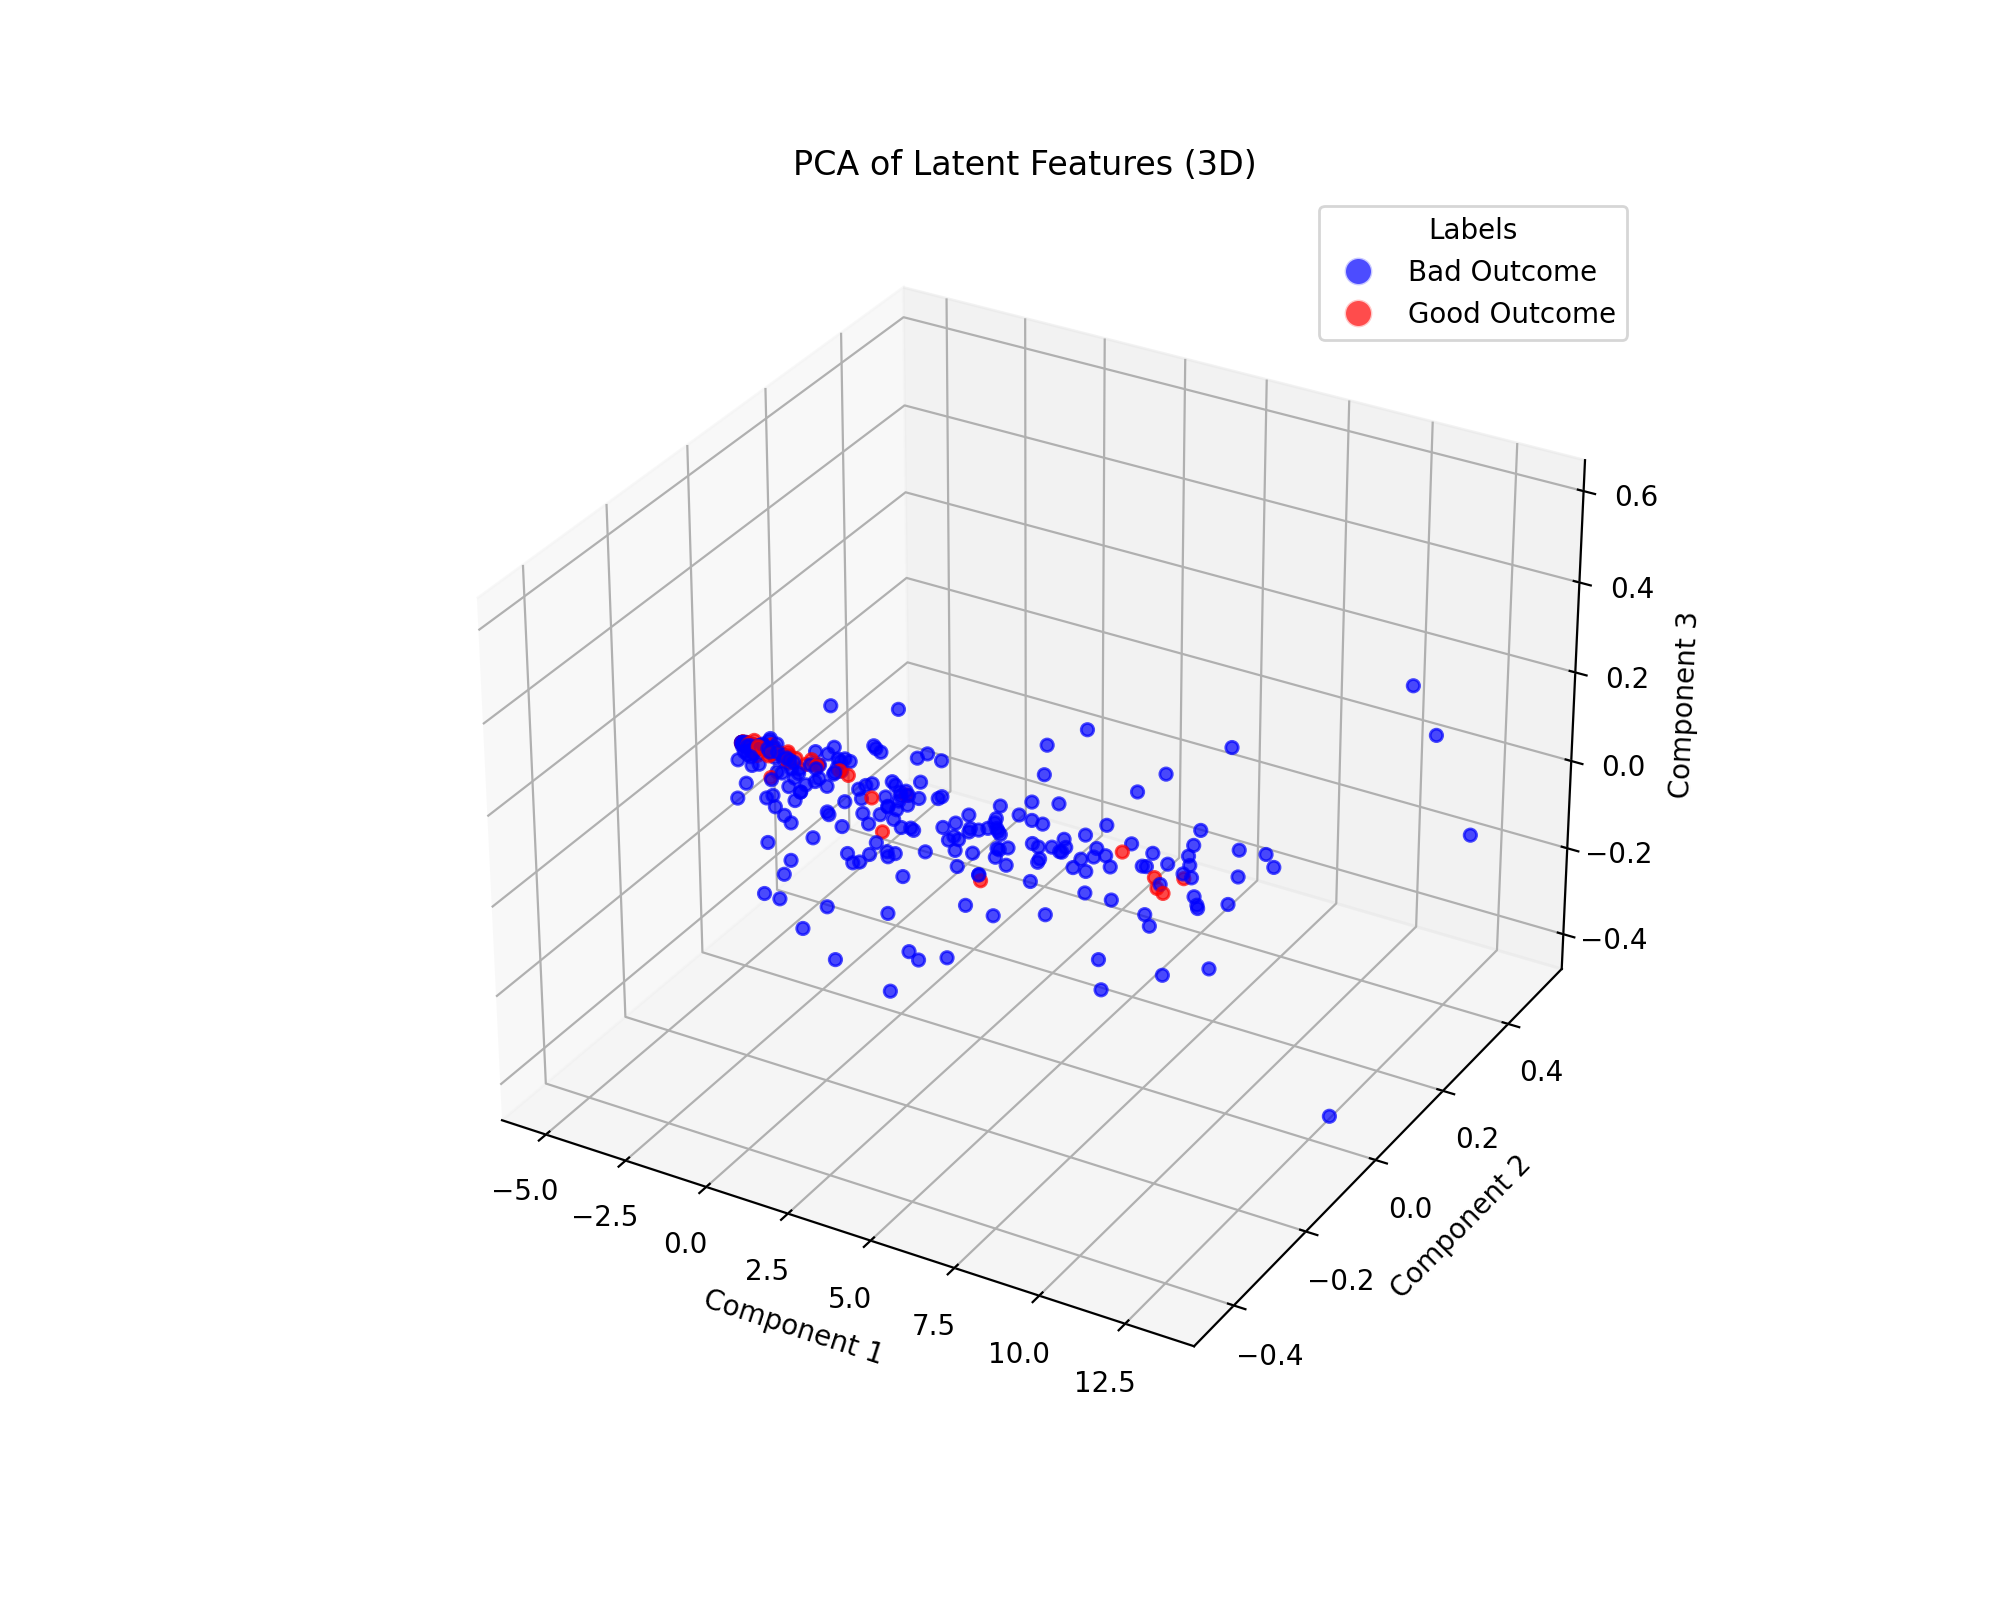

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D


def visualize_latent_space(latent_features, labels, method='pca', dimensions=2):
    """
    将潜在特征降维并可视化，支持二维或三维图形。
    
    参数：
    - latent_features: 2D numpy array，形状为 (样本数, 特征维度)
    - labels: 1D numpy array，样本标签
    - method: str, 降维方法 ('pca' 或 'tsne')
    - dimensions: int, 降维到2维或3维 (2或3)
    """
    if dimensions not in [2, 3]:
        raise ValueError("Dimensions must be 2 or 3.")

    # 降维
    if method == 'pca':
        reducer = PCA(n_components=dimensions)
        reduced_features = reducer.fit_transform(latent_features)
        title = f"PCA of Latent Features ({dimensions}D)"
    elif method == 'tsne':
        reducer = TSNE(n_components=dimensions, random_state=42)
        reduced_features = reducer.fit_transform(latent_features)
        title = f"t-SNE of Latent Features ({dimensions}D)"
    else:
        raise ValueError("Method should be 'pca' or 'tsne'.")

    # 可视化
    if dimensions == 2:
        %matplotlib inline
        # 二维散点图
        plt.figure(figsize=(10, 8))
        color_map = {0: 'blue', 1: 'red'}
        label_map = {0: 'Bad Outcome', 1: 'Good Outcome'}
        colors = [color_map[label] for label in labels]
        scatter = plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=colors, alpha=0.7)
        
        # 创建自定义图例
        handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, alpha=0.7, label='Bad Outcome'),
                   plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, alpha=0.7, label='Good Outcome')]
        plt.legend(handles=handles, title="Labels")
        plt.title(title)
        plt.xlabel("Component 1")
        plt.ylabel("Component 2")
        plt.grid(True)
        plt.show()

        
    elif dimensions == 3:
        %matplotlib notebook
        # 三维散点图
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')
        color_map = {0: 'blue', 1: 'red'}
        label_map = {0: 'Bad Outcome', 1: 'Good Outcome'}
        colors = [color_map[label] for label in labels]

        scatter = ax.scatter(reduced_features[:, 0], reduced_features[:, 1], reduced_features[:, 2], c=colors, alpha=0.7)

        # 创建自定义图例
        handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, alpha=0.7, label='Bad Outcome'),
                   plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, alpha=0.7, label='Good Outcome')]
        ax.legend(handles=handles, title="Labels")
        ax.set_title(title)
        ax.set_xlabel("Component 1")
        ax.set_ylabel("Component 2")
        ax.set_zlabel("Component 3")

        # 显示交互式图形
        plt.show()

        
        
# 调用可视化函数

visualize_latent_space(latent_features, labels, method='pca', dimensions=3) 
# 可设置'dimensions=2'或'dimensions=3'





In [22]:
from sklearn.model_selection import train_test_split

# 确保 labels 是 numpy 数组
labels = np.array(labels)

# 使用分层划分进行训练和测试集划分
X_train, X_test, y_train, y_test = train_test_split(latent_features, labels, test_size=0.3, stratify=labels, random_state=42)

print(f"Training set class distribution: {np.bincount(y_train)}")
print(f"Testing set class distribution: {np.bincount(y_test)}")

Training set class distribution: [172  36]
Testing set class distribution: [74 16]


In [48]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# 创建并训练 SVM 模型
svm_model = SVC(kernel='linear', C=1.0, class_weight='balanced', random_state=42)
svm_model.fit(X_train, y_train)

# 预测并评估模型
y_pred = svm_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy of SVM on latent features: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Accuracy of SVM on latent features: 0.6556

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.64      0.75        74
           1       0.31      0.75      0.44        16

    accuracy                           0.66        90
   macro avg       0.61      0.69      0.59        90
weighted avg       0.81      0.66      0.70        90


Confusion Matrix:
[[47 27]
 [ 4 12]]


In [49]:
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')  # 设定不使用标签编码
xgb_model.fit(X_train, y_train)

# 9. 预测并评估模型
y_pred = xgb_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)


print(f"Accuracy of XGB on latent features: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Accuracy of XGB on latent features: 0.7667

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.85      0.86        74
           1       0.35      0.38      0.36        16

    accuracy                           0.77        90
   macro avg       0.61      0.61      0.61        90
weighted avg       0.77      0.77      0.77        90


Confusion Matrix:
[[63 11]
 [10  6]]


In [23]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

# 列出所有分类器
classifiers = {
    'SVM': SVC(kernel='linear', C=1.0, class_weight='balanced', random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Logistic Regression': LogisticRegression(max_iter=200, random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=5)
}

# 使用分层划分进行训练和测试集划分
X_train, X_test, y_train, y_test = train_test_split(latent_features, labels, test_size=0.3, stratify=labels, random_state=42)

# 循环遍历每个分类器进行训练和评估
for name, classifier in classifiers.items():
    # 创建并训练分类器
    classifier.fit(X_train, y_train)

    # 预测并评估模型
    y_pred = classifier.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    # 打印分类结果
    print(f"Classifier: {name}")
    print(f"Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("=" * 50)  # 分隔线

Classifier: SVM
Accuracy: 0.7111

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.70      0.80        74
           1       0.35      0.75      0.48        16

    accuracy                           0.71        90
   macro avg       0.64      0.73      0.64        90
weighted avg       0.83      0.71      0.74        90


Confusion Matrix:
[[52 22]
 [ 4 12]]
Classifier: Random Forest
Accuracy: 0.7444

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.85      0.85        74
           1       0.27      0.25      0.26        16

    accuracy                           0.74        90
   macro avg       0.55      0.55      0.55        90
weighted avg       0.74      0.74      0.74        90


Confusion Matrix:
[[63 11]
 [12  4]]
Classifier: Logistic Regression
Accuracy: 0.7667

Classification Report:
              precision    recall  f1-score   support

           0      